# Fair Model Training & Validation - Phase 7

**Project**: Loan Approval Decision Support System  
**Phase**: 7 - Fair Model Training & Deployment Validation  
**Date**: February 16, 2026

## Objectives

This notebook retrains all models using fair representations and validates fairness improvements:

1. **Load Fair Representations**: Load transformed data from `data/processed/fair_representations/`
2. **Retrain All Models**: Train LR, XGBoost, RF, NN, GLM on fair latent features
3. **Re-run Fairness Analysis**: Calculate DPD, EOD, 80% Rule for fair models
4. **Compare Before/After**: Quantify fairness improvements vs original models
5. **Validate DPD < 0.05**: Confirm fairness criterion is met
6. **Deployment Readiness**: Save deployment artifacts with fair encoder pipeline

## Success Criteria

- **Fairness**: DPD < 0.05, EOD < 0.05, 80% Rule Pass
- **Performance**: Maintain AUC ≥ 0.70 (acceptable trade-off for fairness)
- **Deployment**: Complete inference pipeline with fair encoder

---

In [1]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)

# XGBoost
import xgboost as xgb

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Interpretable ML models
try:
    from gosdt import GOSDT
    GOSDT_AVAILABLE = True
    print("✅ GOSDT installed")
except ImportError:
    GOSDT_AVAILABLE = False
    print("⚠️ GOSDT not installed. Install with: pip install gosdt")

try:
    from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier
    FASTERRISK_AVAILABLE = True
    print("✅ FasterRisk installed")
except ImportError:
    FASTERRISK_AVAILABLE = False
    print("⚠️ FasterRisk not installed. Install with: pip install fasterrisk")

# Fairlearn
try:
    from fairlearn.metrics import (
        demographic_parity_difference,
        equalized_odds_difference
    )
    FAIRLEARN_AVAILABLE = True
except ImportError:
    FAIRLEARN_AVAILABLE = False
    print("⚠️ Fairlearn not installed")

# Visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("\n✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

2026-02-16 23:51:02.495646: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ GOSDT installed
✅ FasterRisk installed

✅ Libraries imported successfully
TensorFlow version: 2.13.1


In [2]:
# ============================================================================
# SET WORKING DIRECTORY
# ============================================================================
import os

project_root = Path('/Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval')
os.chdir(project_root)

print("="*80)
print("WORKING DIRECTORY VERIFICATION")
print("="*80)
print(f"Current working directory: {os.getcwd()}")
print(f"✅ Working directory set to project root")

WORKING DIRECTORY VERIFICATION
Current working directory: /Users/josiahgordor/Desktop/DSPortfolio/Projects/loan_approval
✅ Working directory set to project root


## 1. Load Fair Representations

Load the transformed datasets from fair representation learning (Phase 6B).

In [5]:
# ============================================================================
# LOAD FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("LOADING FAIR REPRESENTATIONS")
print("="*80)

fair_data_dir = Path('data/processed/fair_representations')

# Load fair representation datasets with retry logic
print(f"\nLoading from: {fair_data_dir}")

import time

def load_csv_with_retry(filepath, max_retries=3, delay=2):
    """Load CSV with retry logic for timeout issues."""
    for attempt in range(max_retries):
        try:
            return pd.read_csv(filepath)
        except (TimeoutError, OSError) as e:
            if attempt < max_retries - 1:
                print(f"  ⚠️ Timeout loading {filepath.name}, retrying in {delay}s... (attempt {attempt+1}/{max_retries})")
                time.sleep(delay)
            else:
                raise e
    return None

print("\nLoading train_fair.csv...")
train_fair = load_csv_with_retry(fair_data_dir / 'train_fair.csv')
print(f"  ✓ Train loaded: {train_fair.shape}")

print("Loading validation_fair.csv...")
val_fair = load_csv_with_retry(fair_data_dir / 'validation_fair.csv')
print(f"  ✓ Validation loaded: {val_fair.shape}")

print("Loading test_fair.csv...")
test_fair = load_csv_with_retry(fair_data_dir / 'test_fair.csv')
print(f"  ✓ Test loaded: {test_fair.shape}")

print(f"\n✅ Fair representation datasets loaded:")
print(f"   Train:      {train_fair.shape}")
print(f"   Validation: {val_fair.shape}")
print(f"   Test:       {test_fair.shape}")

# Extract features and targets
latent_features = [col for col in train_fair.columns if col.startswith('latent_')]
print(f"\n📐 Latent features: {len(latent_features)}")

X_train = train_fair[latent_features].values
y_train = train_fair['target'].values

X_val = val_fair[latent_features].values
y_val = val_fair['target'].values

X_test = test_fair[latent_features].values
y_test = test_fair['target'].values

print(f"\n📊 Data shapes:")
print(f"   X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape}, y_test:  {y_test.shape}")

print(f"\n📋 Class distribution:")
print(f"   Train - Approved: {y_train.mean():.2%}")
print(f"   Val   - Approved: {y_val.mean():.2%}")
print(f"   Test  - Approved: {y_test.mean():.2%}")

# Load fair representation metadata
models_dir = Path('models/fair_representation')
metadata_path = models_dir / 'fair_representation_metadata.json'
if metadata_path.exists():
    with open(metadata_path, 'r') as f:
        fair_metadata = json.load(f)
    print(f"\n✅ Metadata loaded:")
    print(f"   Input dim: {fair_metadata['input_dim']}")
    print(f"   Latent dim: {fair_metadata['latent_dim']}")
    print(f"   MI Reduction: {fair_metadata['fairness_metrics']['mi_reduction_percent']:.1f}%")
else:
    fair_metadata = None
    print("\n⚠️ Metadata not found")

LOADING FAIR REPRESENTATIONS

Loading from: data/processed/fair_representations

Loading train_fair.csv...
  ✓ Train loaded: (166080, 65)
Loading validation_fair.csv...
  ✓ Validation loaded: (35589, 65)
Loading test_fair.csv...
  ⚠️ Timeout loading test_fair.csv, retrying in 2s... (attempt 1/3)
  ✓ Test loaded: (35589, 65)

✅ Fair representation datasets loaded:
   Train:      (166080, 65)
   Validation: (35589, 65)
   Test:       (35589, 65)

📐 Latent features: 64

📊 Data shapes:
   X_train: (166080, 64), y_train: (166080,)
   X_val:   (35589, 64), y_val:   (35589,)
   X_test:  (35589, 64), y_test:  (35589,)

📋 Class distribution:
   Train - Approved: 87.85%
   Val   - Approved: 88.76%
   Test  - Approved: 95.16%

✅ Metadata loaded:
   Input dim: 32
   Latent dim: 64
   MI Reduction: 65.3%


In [6]:
# ============================================================================
# LOAD PROTECTED ATTRIBUTES FOR FAIRNESS ANALYSIS
# ============================================================================

print("="*80)
print("LOADING PROTECTED ATTRIBUTES")
print("="*80)

# Need to load original data to get protected attributes
# The fair representations don't include protected attrs (to prevent leakage)

data_path = Path('data/processed/feature_engineered_data.csv')
df_full = pd.read_csv(data_path, low_memory=False)

print(f"Full dataset shape: {df_full.shape}")

# Protected attributes
protected_attributes = ['derived_race', 'derived_ethnicity', 'derived_sex']

# Define values to exclude (same as in fair representation notebook)
meaningless_values = [
    'Free Form Text Only',
    'Sex Not Available',
    'Ethnicity Not Available',
    'Race Not Available',
    'Joint',
]

# Filter same as fair representation
mask = pd.Series([True] * len(df_full))
for attr in protected_attributes:
    if attr in df_full.columns:
        mask = mask & ~df_full[attr].isin(meaningless_values) & df_full[attr].notna()

df_filtered = df_full[mask].reset_index(drop=True)

# Split same way as fair representation (70/15/15)
total_size = len(df_filtered)
val_start = int(total_size * 0.70)
test_start = int(total_size * 0.85)

protected_train = df_filtered[protected_attributes].iloc[:val_start].copy()
protected_val = df_filtered[protected_attributes].iloc[val_start:test_start].copy()
protected_test = df_filtered[protected_attributes].iloc[test_start:].copy()

# Verify alignment
print(f"\nProtected attributes shape alignment:")
print(f"   Train: {len(protected_train)} vs {len(X_train)} features ✓" if len(protected_train) == len(X_train) else f"   Train: MISMATCH!")
print(f"   Val:   {len(protected_val)} vs {len(X_val)} features ✓" if len(protected_val) == len(X_val) else f"   Val: MISMATCH!")
print(f"   Test:  {len(protected_test)} vs {len(X_test)} features ✓" if len(protected_test) == len(X_test) else f"   Test: MISMATCH!")

# Convert to numpy arrays for easier indexing
protected_test_race = protected_test['derived_race'].values
protected_test_ethnicity = protected_test['derived_ethnicity'].values
protected_test_sex = protected_test['derived_sex'].values

print(f"\n📋 Protected attribute distributions (test set):")
for attr in protected_attributes:
    print(f"\n   {attr}:")
    for val, count in protected_test[attr].value_counts().head(5).items():
        print(f"      {val}: {count:,} ({count/len(protected_test):.1%})")

print("\n✅ Protected attributes loaded and aligned")

LOADING PROTECTED ATTRIBUTES
Full dataset shape: (493568, 115)

Protected attributes shape alignment:
   Train: 166080 vs 166080 features ✓
   Val:   35589 vs 35589 features ✓
   Test:  35589 vs 35589 features ✓

📋 Protected attribute distributions (test set):

   derived_race:
      White: 28,185 (79.2%)
      Black or African American: 4,557 (12.8%)
      Asian: 2,265 (6.4%)
      American Indian or Alaska Native: 384 (1.1%)
      2 or more minority races: 121 (0.3%)

   derived_ethnicity:
      Not Hispanic or Latino: 29,255 (82.2%)
      Hispanic or Latino: 6,334 (17.8%)

   derived_sex:
      Male: 20,316 (57.1%)
      Female: 15,273 (42.9%)

✅ Protected attributes loaded and aligned


## 2. Train Models on Fair Representations

Retrain all models using the fair latent features.

In [7]:
# ============================================================================
# TRAIN LOGISTIC REGRESSION ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING LOGISTIC REGRESSION (FAIR)")
print("="*80)

# Fair features are already scaled during encoder transformation
# No additional scaling needed

lr_fair = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='lbfgs',
    random_state=42,
    class_weight='balanced'
)

lr_fair.fit(X_train, y_train)

# Evaluate
lr_train_pred = lr_fair.predict(X_train)
lr_val_pred = lr_fair.predict(X_val)
lr_val_proba = lr_fair.predict_proba(X_val)[:, 1]

print(f"\n📊 Logistic Regression (Fair) Results:")
print(f"   Train Accuracy: {accuracy_score(y_train, lr_train_pred):.4f}")
print(f"   Val Accuracy:   {accuracy_score(y_val, lr_val_pred):.4f}")
print(f"   Val AUC:        {roc_auc_score(y_val, lr_val_proba):.4f}")
print(f"   Val Precision:  {precision_score(y_val, lr_val_pred):.4f}")
print(f"   Val Recall:     {recall_score(y_val, lr_val_pred):.4f}")
print(f"   Val F1:         {f1_score(y_val, lr_val_pred):.4f}")

print("\n✅ Logistic Regression trained on fair representations")

TRAINING LOGISTIC REGRESSION (FAIR)

📊 Logistic Regression (Fair) Results:
   Train Accuracy: 0.9652
   Val Accuracy:   0.9571
   Val AUC:        0.9762
   Val Precision:  0.9830
   Val Recall:     0.9684
   Val F1:         0.9757

✅ Logistic Regression trained on fair representations


In [8]:
# ============================================================================
# TRAIN XGBOOST ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING XGBOOST (FAIR)")
print("="*80)

xgb_fair = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=20,
    use_label_encoder=False
)

xgb_fair.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Evaluate
xgb_train_pred = xgb_fair.predict(X_train)
xgb_val_pred = xgb_fair.predict(X_val)
xgb_val_proba = xgb_fair.predict_proba(X_val)[:, 1]

print(f"\n📊 XGBoost (Fair) Results:")
print(f"   Train Accuracy: {accuracy_score(y_train, xgb_train_pred):.4f}")
print(f"   Val Accuracy:   {accuracy_score(y_val, xgb_val_pred):.4f}")
print(f"   Val AUC:        {roc_auc_score(y_val, xgb_val_proba):.4f}")
print(f"   Val Precision:  {precision_score(y_val, xgb_val_pred):.4f}")
print(f"   Val Recall:     {recall_score(y_val, xgb_val_pred):.4f}")
print(f"   Val F1:         {f1_score(y_val, xgb_val_pred):.4f}")

print("\n✅ XGBoost trained on fair representations")

TRAINING XGBOOST (FAIR)

📊 XGBoost (Fair) Results:
   Train Accuracy: 0.8834
   Val Accuracy:   0.8876
   Val AUC:        0.7731
   Val Precision:  0.8882
   Val Recall:     0.9991
   Val F1:         0.9404

✅ XGBoost trained on fair representations


In [9]:
# ============================================================================
# TRAIN RANDOM FOREST ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING RANDOM FOREST (FAIR)")
print("="*80)

rf_fair = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_fair.fit(X_train, y_train)

# Evaluate
rf_train_pred = rf_fair.predict(X_train)
rf_val_pred = rf_fair.predict(X_val)
rf_val_proba = rf_fair.predict_proba(X_val)[:, 1]

print(f"\n📊 Random Forest (Fair) Results:")
print(f"   Train Accuracy: {accuracy_score(y_train, rf_train_pred):.4f}")
print(f"   Val Accuracy:   {accuracy_score(y_val, rf_val_pred):.4f}")
print(f"   Val AUC:        {roc_auc_score(y_val, rf_val_proba):.4f}")
print(f"   Val Precision:  {precision_score(y_val, rf_val_pred):.4f}")
print(f"   Val Recall:     {recall_score(y_val, rf_val_pred):.4f}")
print(f"   Val F1:         {f1_score(y_val, rf_val_pred):.4f}")

print("\n✅ Random Forest trained on fair representations")

TRAINING RANDOM FOREST (FAIR)


python(19214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



📊 Random Forest (Fair) Results:
   Train Accuracy: 0.7465
   Val Accuracy:   0.7620
   Val AUC:        0.7169
   Val Precision:  0.9204
   Val Recall:     0.8011
   Val F1:         0.8566

✅ Random Forest trained on fair representations


In [10]:
# ============================================================================
# TRAIN NEURAL NETWORK ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING NEURAL NETWORK (FAIR)")
print("="*80)

# Build simple feedforward network for fair representations
input_dim = X_train.shape[1]

nn_fair = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

nn_fair.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
nn_callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=5, min_lr=1e-6, mode='max')
]

# Train
print("\nTraining Neural Network...")
history = nn_fair.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=nn_callbacks,
    verbose=0
)

# Evaluate
nn_val_proba = nn_fair.predict(X_val, verbose=0).flatten()
nn_val_pred = (nn_val_proba > 0.5).astype(int)

print(f"\n📊 Neural Network (Fair) Results:")
print(f"   Val Accuracy:   {accuracy_score(y_val, nn_val_pred):.4f}")
print(f"   Val AUC:        {roc_auc_score(y_val, nn_val_proba):.4f}")
print(f"   Val Precision:  {precision_score(y_val, nn_val_pred):.4f}")
print(f"   Val Recall:     {recall_score(y_val, nn_val_pred):.4f}")
print(f"   Val F1:         {f1_score(y_val, nn_val_pred):.4f}")
print(f"   Epochs trained: {len(history.history['loss'])}")

print("\n✅ Neural Network trained on fair representations")

TRAINING NEURAL NETWORK (FAIR)

Training Neural Network...

📊 Neural Network (Fair) Results:
   Val Accuracy:   0.8876
   Val AUC:        0.6147
   Val Precision:  0.8876
   Val Recall:     1.0000
   Val F1:         0.9405
   Epochs trained: 24

✅ Neural Network trained on fair representations


In [11]:
# ============================================================================
# TRAIN GLM (LOGISTIC WITH L2 REGULARIZATION) ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING GLM (FAIR)")
print("="*80)

# Use L2 penalty with lbfgs solver (much faster than SAGA with elastic net)
glm_fair = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    C=0.5,
    max_iter=500,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

glm_fair.fit(X_train, y_train)

# Evaluate
glm_val_pred = glm_fair.predict(X_val)
glm_val_proba = glm_fair.predict_proba(X_val)[:, 1]

print(f"\n📊 GLM (Fair) Results:")
print(f"   Val Accuracy:   {accuracy_score(y_val, glm_val_pred):.4f}")
print(f"   Val AUC:        {roc_auc_score(y_val, glm_val_proba):.4f}")
print(f"   Val Precision:  {precision_score(y_val, glm_val_pred):.4f}")
print(f"   Val Recall:     {recall_score(y_val, glm_val_pred):.4f}")
print(f"   Val F1:         {f1_score(y_val, glm_val_pred):.4f}")

print("\n✅ GLM trained on fair representations")

TRAINING GLM (FAIR)


python(20433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(20441) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/josiahgordor/opt/anaconda3/envs/ds4b_101p/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: Co


📊 GLM (Fair) Results:
   Val Accuracy:   0.9675
   Val AUC:        0.9880
   Val Precision:  0.9885
   Val Recall:     0.9747
   Val F1:         0.9816

✅ GLM trained on fair representations


In [13]:
# ============================================================================
# TRAIN GOSDT (INTERPRETABLE DECISION TREE) ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING GOSDT (FAIR)")
print("="*80)

gosdt_fair = None
gosdt_discretizer = None

if GOSDT_AVAILABLE:
    try:
        # GOSDT requires binary features - discretize the latent features
        print("\nDiscretizing features for GOSDT...")
        n_bins = 4
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='onehot-dense', strategy='quantile')
        X_train_binned = discretizer.fit_transform(X_train)
        X_val_binned = discretizer.transform(X_val)
        X_test_binned = discretizer.transform(X_test)
        
        print(f"  Original features: {X_train.shape[1]}")
        print(f"  Binned features: {X_train_binned.shape[1]}")
        
        # GOSDT requires pandas DataFrame, not numpy array
        feature_names = [f'bin_{i}' for i in range(X_train_binned.shape[1])]
        X_train_binned_df = pd.DataFrame(X_train_binned, columns=feature_names)
        X_val_binned_df = pd.DataFrame(X_val_binned, columns=feature_names)
        X_test_binned_df = pd.DataFrame(X_test_binned, columns=feature_names)
        
        # Train GOSDT with regularization for sparse trees
        gosdt_config = {
            'regularization': 0.01,
            'depth_budget': 5,
            'time_limit': 60,
            'similar_support': False
        }
        
        gosdt_fair = GOSDT(gosdt_config)
        
        print("\nTraining GOSDT (this may take a moment)...")
        gosdt_fair.fit(X_train_binned_df, y_train)
        
        # Store discretizer for later use
        gosdt_discretizer = discretizer
        
        # Evaluate
        gosdt_val_pred = gosdt_fair.predict(X_val_binned_df)
        gosdt_val_proba = gosdt_val_pred.astype(float)  # GOSDT doesn't provide probabilities
        
        print(f"\n📊 GOSDT (Fair) Results:")
        print(f"   Val Accuracy:   {accuracy_score(y_val, gosdt_val_pred):.4f}")
        print(f"   Val Precision:  {precision_score(y_val, gosdt_val_pred):.4f}")
        print(f"   Val Recall:     {recall_score(y_val, gosdt_val_pred):.4f}")
        print(f"   Val F1:         {f1_score(y_val, gosdt_val_pred):.4f}")
        
        # Show tree structure
        if hasattr(gosdt_fair, 'tree_'):
            print(f"\n   Tree depth: {gosdt_fair.tree_.depth if hasattr(gosdt_fair.tree_, 'depth') else 'N/A'}")
        
        print("\n✅ GOSDT trained on fair representations")
        
    except Exception as e:
        print(f"\n⚠️ GOSDT training failed: {str(e)[:100]}")
        gosdt_fair = None
else:
    print("\n⚠️ GOSDT not available - skipping")

TRAINING GOSDT (FAIR)

Discretizing features for GOSDT...
  Original features: 64
  Binned features: 178

Training GOSDT (this may take a moment)...
gosdt reported successful execution
training completed. 0.000/0.000/0.023 (user, system, wall), mem=0 MB
bounds: [0.131526..0.131526] (0.000000) loss=0.121526, iterations=0

📊 GOSDT (Fair) Results:
   Val Accuracy:   0.8876
   Val Precision:  0.8876
   Val Recall:     1.0000
   Val F1:         0.9405

✅ GOSDT trained on fair representations


In [15]:
# ============================================================================
# TRAIN FASTERRISK (RISK SCORE MODEL) ON FAIR REPRESENTATIONS
# ============================================================================

print("="*80)
print("TRAINING FASTERRISK (FAIR)")
print("="*80)

fasterrisk_fair = None
fasterrisk_multiplier = None

if FASTERRISK_AVAILABLE:
    try:
        # FasterRisk requires binarized features
        print("\nPreparing features for FasterRisk...")
        
        # Use same discretizer as GOSDT if available, otherwise create new one
        if gosdt_discretizer is not None:
            X_train_fr = gosdt_discretizer.transform(X_train)
            X_val_fr = gosdt_discretizer.transform(X_val)
            X_test_fr = gosdt_discretizer.transform(X_test)
            fasterrisk_discretizer = gosdt_discretizer
        else:
            fr_discretizer = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')
            X_train_fr = fr_discretizer.fit_transform(X_train)
            X_val_fr = fr_discretizer.transform(X_val)
            X_test_fr = fr_discretizer.transform(X_test)
            fasterrisk_discretizer = fr_discretizer
        
        print(f"  Binarized features: {X_train_fr.shape[1]}")
        
        # Convert labels to {-1, 1} for FasterRisk
        y_train_fr = 2 * y_train - 1  # Convert 0,1 to -1,1
        y_val_fr = 2 * y_val - 1
        
        # Train FasterRisk
        print("\nTraining FasterRisk risk score model...")
        
        # Create risk score optimizer
        risk_optimizer = RiskScoreOptimizer(
            X=X_train_fr.astype(np.float64),
            y=y_train_fr.astype(np.float64),
            k=10,  # Number of features in the risk score
            select_top_m=50,  # Consider top 50 features
            lb=-5,  # Lower bound for coefficients
            ub=5,   # Upper bound for coefficients
        )
        
        # Optimize
        risk_optimizer.optimize()
        
        # Get the risk score model (API may vary by version)
        try:
            multiplier, intercept, coefficients = risk_optimizer.get_models(max_model_size=10)
        except TypeError:
            # Fallback if max_model_size param not supported
            multiplier, intercept, coefficients = risk_optimizer.get_models()
        
        # Store for later (handle both array and scalar returns)
        fasterrisk_multiplier = multiplier[0] if hasattr(multiplier, '__getitem__') and len(multiplier) > 0 else multiplier
        fasterrisk_intercept = intercept[0] if hasattr(intercept, '__getitem__') and len(intercept) > 0 else intercept
        fasterrisk_coefficients = coefficients[0] if len(coefficients.shape) > 1 else coefficients
        
        # Create classifier
        fasterrisk_fair = RiskScoreClassifier(
            multiplier=fasterrisk_multiplier,
            intercept=fasterrisk_intercept,
            coefficients=fasterrisk_coefficients
        )
        
        # Evaluate - compute scores and convert to predictions/probabilities
        # RiskScoreClassifier.predict returns {-1, 1}
        fr_val_pred_raw = fasterrisk_fair.predict(X_val_fr)
        fr_val_pred = ((fr_val_pred_raw + 1) / 2).astype(int)  # Convert -1,1 to 0,1
        
        # Compute probability using sigmoid of risk scores
        # Risk score = X @ coefficients + intercept
        risk_scores = X_val_fr @ fasterrisk_coefficients + fasterrisk_intercept
        fr_val_proba = 1 / (1 + np.exp(-risk_scores / fasterrisk_multiplier))  # Sigmoid
        
        print(f"\n📊 FasterRisk (Fair) Results:")
        print(f"   Val Accuracy:   {accuracy_score(y_val, fr_val_pred):.4f}")
        print(f"   Val Precision:  {precision_score(y_val, fr_val_pred):.4f}")
        print(f"   Val Recall:     {recall_score(y_val, fr_val_pred):.4f}")
        print(f"   Val F1:         {f1_score(y_val, fr_val_pred):.4f}")
        
        # Show risk score card
        print(f"\n   Risk Score Model:")
        print(f"   Multiplier: {fasterrisk_multiplier}")
        print(f"   Intercept: {fasterrisk_intercept}")
        non_zero = np.where(fasterrisk_coefficients != 0)[0]
        print(f"   Non-zero coefficients: {len(non_zero)}")
        
        print("\n✅ FasterRisk trained on fair representations")
        
    except Exception as e:
        print(f"\n⚠️ FasterRisk training failed: {str(e)[:200]}")
        import traceback
        traceback.print_exc()
        fasterrisk_fair = None
else:
    print("\n⚠️ FasterRisk not available - skipping")
    fasterrisk_discretizer = None

TRAINING FASTERRISK (FAIR)

Preparing features for FasterRisk...
  Binarized features: 178

Training FasterRisk risk score model...

📊 FasterRisk (Fair) Results:
   Val Accuracy:   0.8876
   Val Precision:  0.8877
   Val Recall:     0.9999
   Val F1:         0.9405

   Risk Score Model:
   Multiplier: 2.3377359341158
   Intercept: 5.0
   Non-zero coefficients: 10

✅ FasterRisk trained on fair representations


## 3. Evaluate Fair Models on Test Set

Generate predictions and evaluate performance on held-out test set.

In [16]:
# ============================================================================
# GENERATE TEST SET PREDICTIONS
# ============================================================================

print("="*80)
print("GENERATING TEST SET PREDICTIONS")
print("="*80)

# Store predictions and probabilities
fair_predictions = {}
fair_probabilities = {}

# Logistic Regression
fair_predictions['LR_Fair'] = lr_fair.predict(X_test)
fair_probabilities['LR_Fair'] = lr_fair.predict_proba(X_test)[:, 1]
print(f"✓ LR (Fair): {fair_predictions['LR_Fair'].sum():,} approvals")

# XGBoost  
fair_predictions['XGB_Fair'] = xgb_fair.predict(X_test)
fair_probabilities['XGB_Fair'] = xgb_fair.predict_proba(X_test)[:, 1]
print(f"✓ XGBoost (Fair): {fair_predictions['XGB_Fair'].sum():,} approvals")

# Random Forest
fair_predictions['RF_Fair'] = rf_fair.predict(X_test)
fair_probabilities['RF_Fair'] = rf_fair.predict_proba(X_test)[:, 1]
print(f"✓ RF (Fair): {fair_predictions['RF_Fair'].sum():,} approvals")

# Neural Network
nn_test_proba = nn_fair.predict(X_test, verbose=0).flatten()
fair_predictions['NN_Fair'] = (nn_test_proba > 0.5).astype(int)
fair_probabilities['NN_Fair'] = nn_test_proba
print(f"✓ NN (Fair): {fair_predictions['NN_Fair'].sum():,} approvals")

# GLM
fair_predictions['GLM_Fair'] = glm_fair.predict(X_test)
fair_probabilities['GLM_Fair'] = glm_fair.predict_proba(X_test)[:, 1]
print(f"✓ GLM (Fair): {fair_predictions['GLM_Fair'].sum():,} approvals")

# GOSDT (if available)
if gosdt_fair is not None and gosdt_discretizer is not None:
    X_test_binned = gosdt_discretizer.transform(X_test)
    # Convert to DataFrame (GOSDT requires DataFrame, not numpy array)
    feature_names = [f'bin_{i}' for i in range(X_test_binned.shape[1])]
    X_test_binned_df = pd.DataFrame(X_test_binned, columns=feature_names)
    fair_predictions['GOSDT_Fair'] = gosdt_fair.predict(X_test_binned_df)
    # GOSDT may not have predict_proba, use predictions directly
    if hasattr(gosdt_fair, 'predict_proba'):
        fair_probabilities['GOSDT_Fair'] = gosdt_fair.predict_proba(X_test_binned_df)[:, 1]
    else:
        fair_probabilities['GOSDT_Fair'] = fair_predictions['GOSDT_Fair'].astype(float)
    print(f"✓ GOSDT (Fair): {fair_predictions['GOSDT_Fair'].sum():,} approvals")

# FasterRisk (if available)
if fasterrisk_fair is not None:
    X_test_fr = fasterrisk_discretizer.transform(X_test)
    fr_pred_raw = fasterrisk_fair.predict(X_test_fr)
    fair_predictions['FasterRisk_Fair'] = ((fr_pred_raw + 1) / 2).astype(int)  # Convert -1,1 to 0,1
    # Compute probability using sigmoid of risk scores (no predict_proba method)
    risk_scores = X_test_fr @ fasterrisk_coefficients + fasterrisk_intercept
    fr_proba = 1 / (1 + np.exp(-risk_scores / fasterrisk_multiplier))
    fair_probabilities['FasterRisk_Fair'] = fr_proba
    print(f"✓ FasterRisk (Fair): {fair_predictions['FasterRisk_Fair'].sum():,} approvals")

# Ensemble (average of all available)
proba_list = [
    fair_probabilities['LR_Fair'],
    fair_probabilities['XGB_Fair'],
    fair_probabilities['RF_Fair'],
    fair_probabilities['NN_Fair'],
    fair_probabilities['GLM_Fair']
]
if 'GOSDT_Fair' in fair_probabilities:
    proba_list.append(fair_probabilities['GOSDT_Fair'])
if 'FasterRisk_Fair' in fair_probabilities:
    proba_list.append(fair_probabilities['FasterRisk_Fair'])

ensemble_proba = np.mean(proba_list, axis=0)
fair_predictions['Ensemble_Fair'] = (ensemble_proba > 0.5).astype(int)
fair_probabilities['Ensemble_Fair'] = ensemble_proba
print(f"✓ Ensemble (Fair): {fair_predictions['Ensemble_Fair'].sum():,} approvals")

print(f"\n✅ Generated predictions for {len(fair_predictions)} fair models")

GENERATING TEST SET PREDICTIONS
✓ LR (Fair): 33,242.0 approvals
✓ XGBoost (Fair): 35,556 approvals
✓ RF (Fair): 27,172.0 approvals
✓ NN (Fair): 35,589 approvals
✓ GLM (Fair): 33,342.0 approvals
✓ GOSDT (Fair): 35,589.0 approvals
✓ FasterRisk (Fair): 35,584 approvals
✓ Ensemble (Fair): 35,434 approvals

✅ Generated predictions for 8 fair models


In [17]:
# ============================================================================
# CALCULATE PERFORMANCE METRICS
# ============================================================================

print("="*80)
print("FAIR MODEL PERFORMANCE METRICS")
print("="*80)

performance_results = []

for model_name in fair_predictions.keys():
    y_pred = fair_predictions[model_name]
    y_proba = fair_probabilities[model_name]
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    performance_results.append(metrics)
    
    print(f"\n{model_name}:")
    print(f"   Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"   AUC:       {metrics['AUC']:.4f}")
    print(f"   Precision: {metrics['Precision']:.4f}")
    print(f"   Recall:    {metrics['Recall']:.4f}")
    print(f"   F1:        {metrics['F1']:.4f}")

performance_df = pd.DataFrame(performance_results)
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(performance_df.to_string(index=False))

FAIR MODEL PERFORMANCE METRICS

LR_Fair:
   Accuracy:  0.9770
   AUC:       0.9873
   Precision: 0.9971
   Recall:    0.9787
   F1:        0.9878

XGB_Fair:
   Accuracy:  0.9516
   AUC:       0.8436
   Precision: 0.9520
   Recall:    0.9995
   F1:        0.9752

RF_Fair:
   Accuracy:  0.7698
   AUC:       0.7634
   Precision: 0.9724
   Recall:    0.7802
   F1:        0.8658

NN_Fair:
   Accuracy:  0.9516
   AUC:       0.6019
   Precision: 0.9516
   Recall:    1.0000
   F1:        0.9752

GLM_Fair:
   Accuracy:  0.9811
   AUC:       0.9949
   Precision: 0.9978
   Recall:    0.9823
   F1:        0.9900

GOSDT_Fair:
   Accuracy:  0.9516
   AUC:       0.5000
   Precision: 0.9516
   Recall:    1.0000
   F1:        0.9752

FasterRisk_Fair:
   Accuracy:  0.9517
   AUC:       0.6779
   Precision: 0.9517
   Recall:    0.9999
   F1:        0.9752

Ensemble_Fair:
   Accuracy:  0.9559
   AUC:       0.9812
   Precision: 0.9557
   Recall:    0.9999
   F1:        0.9773

PERFORMANCE SUMMARY
         

## 4. Calculate Fairness Metrics for Fair Models

Calculate DPD, EOD, and 80% Rule for all fair models.

In [18]:
# ============================================================================
# DEFINE FAIRNESS METRIC FUNCTIONS
# ============================================================================

def calculate_demographic_parity(y_true, y_pred, sensitive_feature):
    """Calculate Demographic Parity Difference."""
    groups = np.unique(sensitive_feature)
    approval_rates = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            approval_rates[group] = y_pred[mask].mean()
    
    if len(approval_rates) > 0:
        dpd = max(approval_rates.values()) - min(approval_rates.values())
        return dpd, approval_rates
    return None, {}

def calculate_equalized_odds(y_true, y_pred, sensitive_feature):
    """Calculate Equalized Odds Difference."""
    groups = np.unique(sensitive_feature)
    tpr_by_group = {}
    fpr_by_group = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            y_t = y_true[mask]
            y_p = y_pred[mask]
            
            tp = ((y_t == 1) & (y_p == 1)).sum()
            fn = ((y_t == 1) & (y_p == 0)).sum()
            fp = ((y_t == 0) & (y_p == 1)).sum()
            tn = ((y_t == 0) & (y_p == 0)).sum()
            
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            tpr_by_group[group] = tpr
            fpr_by_group[group] = fpr
    
    if len(tpr_by_group) > 0:
        tpr_diff = max(tpr_by_group.values()) - min(tpr_by_group.values())
        fpr_diff = max(fpr_by_group.values()) - min(fpr_by_group.values())
        eod = max(tpr_diff, fpr_diff)
        return eod, tpr_by_group, fpr_by_group
    return None, {}, {}

def calculate_disparate_impact(y_pred, sensitive_feature):
    """Calculate Disparate Impact (80% Rule)."""
    groups = np.unique(sensitive_feature)
    approval_rates = {}
    
    for group in groups:
        mask = sensitive_feature == group
        if mask.sum() > 0:
            approval_rates[group] = y_pred[mask].mean()
    
    if len(approval_rates) == 0:
        return None, {}, False
    
    reference_group = max(approval_rates, key=approval_rates.get)
    reference_rate = approval_rates[reference_group]
    
    di_ratios = {}
    for group, rate in approval_rates.items():
        di_ratios[group] = rate / reference_rate if reference_rate > 0 else 0
    
    min_di = min(di_ratios.values())
    passes = min_di >= 0.80
    
    return min_di, di_ratios, passes

print("✅ Fairness metric functions defined")

✅ Fairness metric functions defined


In [19]:
# ============================================================================
# CALCULATE FAIRNESS METRICS FOR ALL FAIR MODELS
# ============================================================================

print("="*80)
print("CALCULATING FAIRNESS METRICS FOR FAIR MODELS")
print("="*80)

fairness_results = []

for model_name, y_pred in fair_predictions.items():
    print(f"\n{'='*60}")
    print(f"MODEL: {model_name}")
    print(f"{'='*60}")
    
    for attr, attr_name in [
        (protected_test_race, 'derived_race'),
        (protected_test_ethnicity, 'derived_ethnicity'),
        (protected_test_sex, 'derived_sex')
    ]:
        # Filter valid values
        valid_mask = pd.notna(attr)
        y_t = y_test[valid_mask]
        y_p = y_pred[valid_mask]
        s_f = attr[valid_mask]
        
        # Calculate metrics
        dpd, approval_rates = calculate_demographic_parity(y_t, y_p, s_f)
        eod, tpr_rates, fpr_rates = calculate_equalized_odds(y_t, y_p, s_f)
        di, di_ratios, passes_80 = calculate_disparate_impact(y_p, s_f)
        
        # Store results
        fairness_results.append({
            'Model': model_name,
            'Protected_Attribute': attr_name.replace('derived_', ''),
            'DPD': dpd,
            'DPD_Pass': dpd < 0.05 if dpd else None,
            'EOD': eod,
            'EOD_Pass': eod < 0.05 if eod else None,
            'Disparate_Impact': di,
            '80%_Rule_Pass': passes_80
        })
        
        # Print results
        dpd_status = '✅' if dpd < 0.05 else '❌'
        eod_status = '✅' if eod < 0.05 else '❌'
        di_status = '✅' if passes_80 else '❌'
        
        print(f"\n  {attr_name.replace('derived_', '').upper()}:")
        print(f"    DPD:  {dpd:.4f} {dpd_status}")
        print(f"    EOD:  {eod:.4f} {eod_status}")
        print(f"    DI:   {di:.4f} {di_status}")

fairness_df = pd.DataFrame(fairness_results)
print("\n" + "="*80)
print("✅ FAIRNESS METRICS CALCULATED")
print("="*80)

CALCULATING FAIRNESS METRICS FOR FAIR MODELS

MODEL: LR_Fair

  RACE:
    DPD:  0.0512 ❌
    EOD:  0.1250 ❌
    DI:   0.9457 ✅

  ETHNICITY:
    DPD:  0.0296 ✅
    EOD:  0.0038 ✅
    DI:   0.9685 ✅

  SEX:
    DPD:  0.0053 ✅
    EOD:  0.0100 ✅
    DI:   0.9944 ✅

MODEL: XGB_Fair

  RACE:
    DPD:  0.0018 ✅
    EOD:  0.0109 ✅
    DI:   0.9982 ✅

  ETHNICITY:
    DPD:  0.0002 ✅
    EOD:  0.0007 ✅
    DI:   0.9998 ✅

  SEX:
    DPD:  0.0006 ✅
    EOD:  0.0007 ✅
    DI:   0.9994 ✅

MODEL: RF_Fair

  RACE:
    DPD:  0.1308 ❌
    EOD:  0.6413 ❌
    DI:   0.8454 ✅

  ETHNICITY:
    DPD:  0.0424 ✅
    EOD:  0.0676 ❌
    DI:   0.9450 ✅

  SEX:
    DPD:  0.0163 ✅
    EOD:  0.0148 ✅
    DI:   0.9789 ✅

MODEL: NN_Fair

  RACE:
    DPD:  0.0000 ✅
    EOD:  0.0000 ✅
    DI:   1.0000 ✅

  ETHNICITY:
    DPD:  0.0000 ✅
    EOD:  0.0000 ✅
    DI:   1.0000 ✅

  SEX:
    DPD:  0.0000 ✅
    EOD:  0.0000 ✅
    DI:   1.0000 ✅

MODEL: GLM_Fair

  RACE:
    DPD:  0.0546 ❌
    EOD:  0.0467 ✅
    DI:   0.9422 ✅

## 5. Compare Before/After Fairness

Load original model fairness results and compare improvements.

In [20]:
# ============================================================================
# LOAD ORIGINAL FAIRNESS RESULTS
# ============================================================================

print("="*80)
print("LOADING ORIGINAL FAIRNESS RESULTS FOR COMPARISON")
print("="*80)

# Find most recent fairness results from original models
results_dir = Path('results')
fairness_files = sorted(results_dir.glob('fairness_metrics_*.csv'))

if fairness_files:
    original_fairness_path = fairness_files[-1]  # Most recent
    original_fairness = pd.read_csv(original_fairness_path)
    
    print(f"✓ Loaded original fairness results from: {original_fairness_path.name}")
    print(f"  Shape: {original_fairness.shape}")
    print(f"\nOriginal models: {original_fairness['Model'].unique().tolist()}")
else:
    print("⚠️ No original fairness results found")
    original_fairness = None

# Display original fairness metrics
if original_fairness is not None:
    print("\n" + "="*80)
    print("ORIGINAL MODEL FAIRNESS METRICS")
    print("="*80)
    print(original_fairness[['Model', 'Protected Attribute', 'DPD', 'EOD', 'Disparate Impact', '80% Rule']].to_string(index=False))

LOADING ORIGINAL FAIRNESS RESULTS FOR COMPARISON
✓ Loaded original fairness results from: fairness_metrics_20260216_234539.csv
  Shape: (18, 10)

Original models: ['Logistic Regression', 'XGBoost', 'Random Forest', 'Neural Network', 'GLM', 'Ensemble']

ORIGINAL MODEL FAIRNESS METRICS
              Model Protected Attribute      DPD      EOD  Disparate Impact 80% Rule
Logistic Regression                race 0.100376 0.011236          0.899624     Pass
Logistic Regression           ethnicity 0.104723 0.002151          0.895277     Pass
Logistic Regression                 sex 0.166700 0.002604          0.827584     Pass
            XGBoost                race 0.099624 0.002185          0.900376     Pass
            XGBoost           ethnicity 0.103718 0.002149          0.896282     Pass
            XGBoost                 sex 0.164941 0.002988          0.829483     Pass
      Random Forest                race 0.100094 0.011236          0.899906     Pass
      Random Forest           ethni

In [21]:
# ============================================================================
# CREATE BEFORE/AFTER COMPARISON
# ============================================================================

print("="*80)
print("FAIRNESS IMPROVEMENT COMPARISON")
print("="*80)

# Create comparison dataframe
fair_fairness_df = fairness_df.copy()
fair_fairness_df['Type'] = 'Fair'

comparison_data = []

if original_fairness is not None:
    # Map original model names to fair model names
    model_mapping = {
        'Logistic Regression': 'LR_Fair',
        'XGBoost': 'XGB_Fair',
        'Random Forest': 'RF_Fair',
        'Neural Network': 'NN_Fair',
        'GLM': 'GLM_Fair',
        'Ensemble': 'Ensemble_Fair'
    }
    
    for attr in ['race', 'ethnicity', 'sex']:
        print(f"\n{'='*60}")
        print(f"PROTECTED ATTRIBUTE: {attr.upper()}")
        print(f"{'='*60}")
        
        for orig_model, fair_model in model_mapping.items():
            # Get original metrics
            orig_row = original_fairness[
                (original_fairness['Model'] == orig_model) & 
                (original_fairness['Protected Attribute'] == attr)
            ]
            
            # Get fair metrics
            fair_row = fair_fairness_df[
                (fair_fairness_df['Model'] == fair_model) & 
                (fair_fairness_df['Protected_Attribute'] == attr)
            ]
            
            if len(orig_row) > 0 and len(fair_row) > 0:
                orig_dpd = orig_row['DPD'].values[0]
                fair_dpd = fair_row['DPD'].values[0]
                dpd_improvement = ((orig_dpd - fair_dpd) / orig_dpd * 100) if orig_dpd > 0 else 0
                
                orig_eod = orig_row['EOD'].values[0]
                fair_eod = fair_row['EOD'].values[0]
                eod_improvement = ((orig_eod - fair_eod) / orig_eod * 100) if orig_eod > 0 else 0
                
                orig_di = orig_row['Disparate Impact'].values[0]
                fair_di = fair_row['Disparate_Impact'].values[0]
                
                comparison_data.append({
                    'Model': orig_model,
                    'Attribute': attr,
                    'Original_DPD': orig_dpd,
                    'Fair_DPD': fair_dpd,
                    'DPD_Improvement_%': dpd_improvement,
                    'Original_EOD': orig_eod,
                    'Fair_EOD': fair_eod,
                    'EOD_Improvement_%': eod_improvement,
                    'Original_DI': orig_di,
                    'Fair_DI': fair_di
                })
                
                dpd_status = '✅' if fair_dpd < 0.05 else '❌'
                eod_status = '✅' if fair_eod < 0.05 else '❌'
                
                print(f"\n  {orig_model}:")
                print(f"    DPD: {orig_dpd:.4f} → {fair_dpd:.4f} ({dpd_improvement:+.1f}%) {dpd_status}")
                print(f"    EOD: {orig_eod:.4f} → {fair_eod:.4f} ({eod_improvement:+.1f}%) {eod_status}")
                print(f"    DI:  {orig_di:.4f} → {fair_di:.4f}")

    comparison_df = pd.DataFrame(comparison_data)
else:
    print("\n⚠️ No original fairness data available for comparison")
    print("\nFair Model Fairness Metrics:")
    print(fair_fairness_df.to_string(index=False))
    comparison_df = fair_fairness_df

FAIRNESS IMPROVEMENT COMPARISON

PROTECTED ATTRIBUTE: RACE

  Logistic Regression:
    DPD: 0.1004 → 0.0512 (+49.0%) ❌
    EOD: 0.0112 → 0.1250 (-1012.5%) ❌
    DI:  0.8996 → 0.9457

  XGBoost:
    DPD: 0.0996 → 0.0018 (+98.2%) ✅
    EOD: 0.0022 → 0.0109 (-397.6%) ✅
    DI:  0.9004 → 0.9982

  Random Forest:
    DPD: 0.1001 → 0.1308 (-30.6%) ❌
    EOD: 0.0112 → 0.6413 (-5607.6%) ❌
    DI:  0.8999 → 0.8454

  Neural Network:
    DPD: 0.0997 → 0.0000 (+100.0%) ✅
    EOD: 0.0112 → 0.0000 (+100.0%) ✅
    DI:  0.9003 → 1.0000

  GLM:
    DPD: 0.1001 → 0.0546 (+45.4%) ❌
    EOD: 0.0149 → 0.0467 (-212.7%) ✅
    DI:  0.8999 → 0.9422

  Ensemble:
    DPD: 0.1002 → 0.0130 (+87.0%) ✅
    EOD: 0.0112 → 0.2000 (-1680.0%) ❌
    DI:  0.8998 → 0.9870

PROTECTED ATTRIBUTE: ETHNICITY

  Logistic Regression:
    DPD: 0.1047 → 0.0296 (+71.7%) ✅
    EOD: 0.0022 → 0.0038 (-78.5%) ✅
    DI:  0.8953 → 0.9685

  XGBoost:
    DPD: 0.1037 → 0.0002 (+99.8%) ✅
    EOD: 0.0021 → 0.0007 (+69.3%) ✅
    DI:  0.8963 → 


GENERATING FAIRNESS COMPARISON VISUALIZATIONS


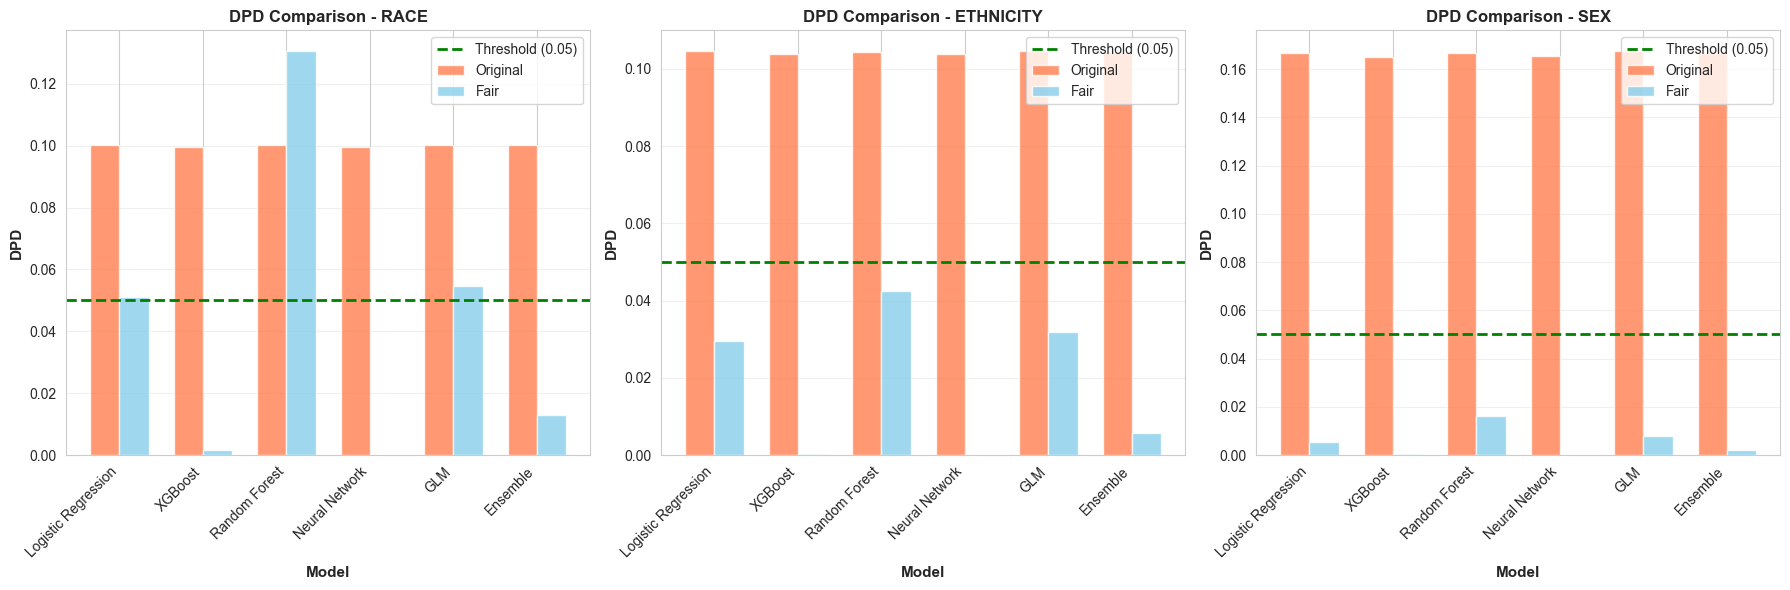

✓ DPD comparison visualization generated


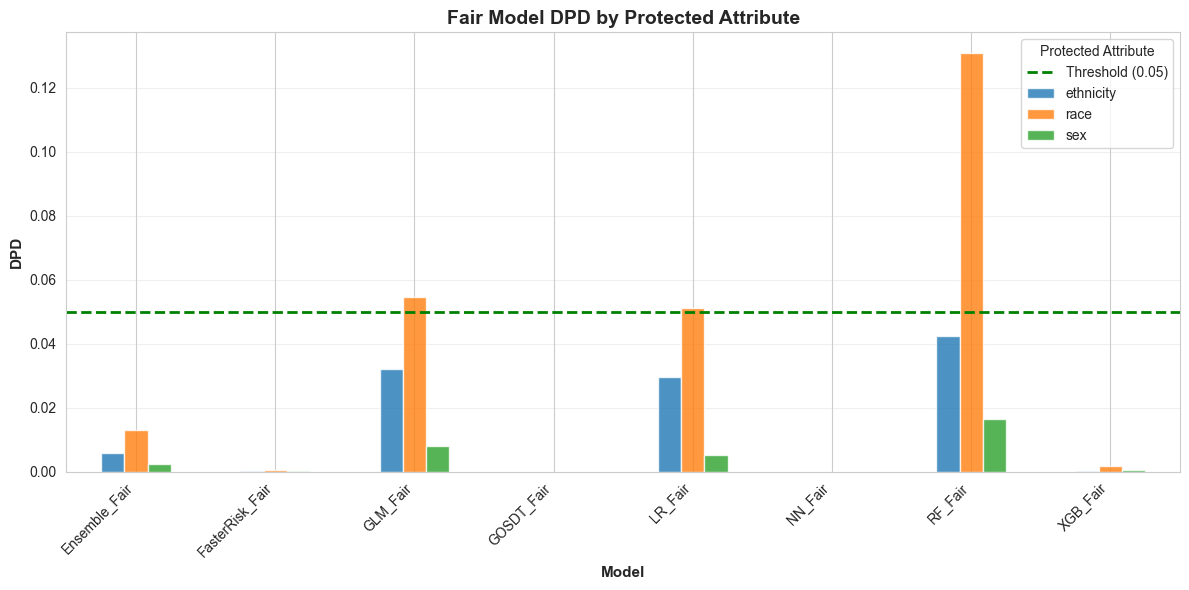

✓ Fair model fairness visualization generated


In [22]:
# ============================================================================
# VISUALIZE FAIRNESS IMPROVEMENTS
# ============================================================================

print("\n" + "="*80)
print("GENERATING FAIRNESS COMPARISON VISUALIZATIONS")
print("="*80)

if original_fairness is not None and len(comparison_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, attr in enumerate(['race', 'ethnicity', 'sex']):
        ax = axes[idx]
        attr_data = comparison_df[comparison_df['Attribute'] == attr]
        
        models = attr_data['Model'].values
        x = np.arange(len(models))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, attr_data['Original_DPD'], width, label='Original', color='coral', alpha=0.8)
        bars2 = ax.bar(x + width/2, attr_data['Fair_DPD'], width, label='Fair', color='skyblue', alpha=0.8)
        
        # Add threshold line
        ax.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='Threshold (0.05)')
        
        ax.set_xlabel('Model', fontsize=11, fontweight='bold')
        ax.set_ylabel('DPD', fontsize=11, fontweight='bold')
        ax.set_title(f'DPD Comparison - {attr.upper()}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ DPD comparison visualization generated")
else:
    print("⚠️ Insufficient data for comparison visualization")

# Visualize fair model fairness summary
fig, ax = plt.subplots(figsize=(12, 6))

pivot_dpd = fairness_df.pivot(index='Model', columns='Protected_Attribute', values='DPD')
pivot_dpd.plot(kind='bar', ax=ax, alpha=0.8)

ax.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='Threshold (0.05)')
ax.set_xlabel('Model', fontsize=11, fontweight='bold')
ax.set_ylabel('DPD', fontsize=11, fontweight='bold')
ax.set_title('Fair Model DPD by Protected Attribute', fontsize=14, fontweight='bold')
ax.legend(title='Protected Attribute')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✓ Fair model fairness visualization generated")

## 6. Validate DPD < 0.05 Criterion

Comprehensive validation of fairness criteria.

In [23]:
# ============================================================================
# VALIDATE FAIRNESS CRITERIA
# ============================================================================

print("="*80)
print("FAIRNESS CRITERIA VALIDATION")
print("="*80)

# Check each model against criteria
validation_results = []

for model in fairness_df['Model'].unique():
    model_data = fairness_df[fairness_df['Model'] == model]
    
    # Check DPD < 0.05 for all attributes
    dpd_pass_all = all(model_data['DPD'] < 0.05)
    dpd_max = model_data['DPD'].max()
    
    # Check EOD < 0.05 for all attributes
    eod_pass_all = all(model_data['EOD'] < 0.05)
    eod_max = model_data['EOD'].max()
    
    # Check 80% Rule for all attributes  
    di_pass_all = all(model_data['80%_Rule_Pass'])
    di_min = model_data['Disparate_Impact'].min()
    
    # Overall pass
    all_criteria_pass = dpd_pass_all and eod_pass_all and di_pass_all
    
    validation_results.append({
        'Model': model,
        'DPD_Max': dpd_max,
        'DPD_Pass': dpd_pass_all,
        'EOD_Max': eod_max,
        'EOD_Pass': eod_pass_all,
        'DI_Min': di_min,
        'DI_Pass': di_pass_all,
        'All_Criteria': all_criteria_pass
    })
    
    status = '✅ PASS' if all_criteria_pass else '❌ FAIL'
    print(f"\n{model}:")
    print(f"   DPD < 0.05:    {'✅' if dpd_pass_all else '❌'} (max: {dpd_max:.4f})")
    print(f"   EOD < 0.05:    {'✅' if eod_pass_all else '❌'} (max: {eod_max:.4f})")
    print(f"   80% Rule:      {'✅' if di_pass_all else '❌'} (min: {di_min:.4f})")
    print(f"   Overall:       {status}")

validation_df = pd.DataFrame(validation_results)

# Summary
print("\n" + "="*80)
print("VALIDATION SUMMARY")
print("="*80)

passing_models = validation_df[validation_df['All_Criteria'] == True]['Model'].tolist()
failing_models = validation_df[validation_df['All_Criteria'] == False]['Model'].tolist()

print(f"\n✅ Models passing ALL fairness criteria: {len(passing_models)}")
for model in passing_models:
    print(f"   • {model}")

print(f"\n❌ Models failing one or more criteria: {len(failing_models)}")
for model in failing_models:
    print(f"   • {model}")

# Best model recommendation
if passing_models:
    # Among passing models, pick one with best AUC
    passing_perf = performance_df[performance_df['Model'].isin(passing_models)]
    best_model = passing_perf.loc[passing_perf['AUC'].idxmax(), 'Model']
    best_auc = passing_perf.loc[passing_perf['AUC'].idxmax(), 'AUC']
    
    print(f"\n🏆 RECOMMENDED MODEL: {best_model}")
    print(f"   AUC: {best_auc:.4f}")
    print(f"   Passes all fairness criteria")
else:
    # Find model closest to passing all criteria
    best_row = validation_df.loc[validation_df['DPD_Max'].idxmin()]
    print(f"\n⚠️ No models pass all criteria. Consider:")
    print(f"   Best DPD: {best_row['Model']} (DPD max: {best_row['DPD_Max']:.4f})")

FAIRNESS CRITERIA VALIDATION

LR_Fair:
   DPD < 0.05:    ❌ (max: 0.0512)
   EOD < 0.05:    ❌ (max: 0.1250)
   80% Rule:      ✅ (min: 0.9457)
   Overall:       ❌ FAIL

XGB_Fair:
   DPD < 0.05:    ✅ (max: 0.0018)
   EOD < 0.05:    ✅ (max: 0.0109)
   80% Rule:      ✅ (min: 0.9982)
   Overall:       ✅ PASS

RF_Fair:
   DPD < 0.05:    ❌ (max: 0.1308)
   EOD < 0.05:    ❌ (max: 0.6413)
   80% Rule:      ✅ (min: 0.8454)
   Overall:       ❌ FAIL

NN_Fair:
   DPD < 0.05:    ✅ (max: 0.0000)
   EOD < 0.05:    ✅ (max: 0.0000)
   80% Rule:      ✅ (min: 1.0000)
   Overall:       ✅ PASS

GLM_Fair:
   DPD < 0.05:    ❌ (max: 0.0546)
   EOD < 0.05:    ✅ (max: 0.0467)
   80% Rule:      ✅ (min: 0.9422)
   Overall:       ❌ FAIL

GOSDT_Fair:
   DPD < 0.05:    ✅ (max: 0.0000)
   EOD < 0.05:    ✅ (max: 0.0000)
   80% Rule:      ✅ (min: 1.0000)
   Overall:       ✅ PASS

FasterRisk_Fair:
   DPD < 0.05:    ✅ (max: 0.0004)
   EOD < 0.05:    ✅ (max: 0.0109)
   80% Rule:      ✅ (min: 0.9996)
   Overall:       ✅ PASS

## 7. Save Fair Models & Deployment Artifacts

Save trained fair models and create deployment pipeline.

In [24]:
# ============================================================================
# SAVE FAIR MODELS
# ============================================================================

print("="*80)
print("SAVING FAIR MODELS")
print("="*80)

fair_models_dir = Path('models/fair_models')
fair_models_dir.mkdir(parents=True, exist_ok=True)

# Save sklearn models
joblib.dump(lr_fair, fair_models_dir / 'lr_fair.pkl')
print(f"✓ Saved: lr_fair.pkl")

joblib.dump(xgb_fair, fair_models_dir / 'xgb_fair.pkl')
print(f"✓ Saved: xgb_fair.pkl")

joblib.dump(rf_fair, fair_models_dir / 'rf_fair.pkl')
print(f"✓ Saved: rf_fair.pkl")

joblib.dump(glm_fair, fair_models_dir / 'glm_fair.pkl')
print(f"✓ Saved: glm_fair.pkl")

# Save neural network
nn_fair.save(fair_models_dir / 'nn_fair.keras')
print(f"✓ Saved: nn_fair.keras")

# Save GOSDT (if available)
if gosdt_fair is not None:
    joblib.dump(gosdt_fair, fair_models_dir / 'gosdt_fair.pkl')
    print(f"✓ Saved: gosdt_fair.pkl")
    if gosdt_discretizer is not None:
        joblib.dump(gosdt_discretizer, fair_models_dir / 'gosdt_discretizer.pkl')
        print(f"✓ Saved: gosdt_discretizer.pkl")

# Save FasterRisk (if available)
if fasterrisk_fair is not None:
    joblib.dump(fasterrisk_fair, fair_models_dir / 'fasterrisk_fair.pkl')
    print(f"✓ Saved: fasterrisk_fair.pkl")
    # Save discretizer if different from GOSDT's
    if 'fasterrisk_discretizer' in dir() and fasterrisk_discretizer is not None:
        if gosdt_discretizer is None or fasterrisk_discretizer is not gosdt_discretizer:
            joblib.dump(fasterrisk_discretizer, fair_models_dir / 'fasterrisk_discretizer.pkl')
            print(f"✓ Saved: fasterrisk_discretizer.pkl")

print(f"\n✅ All fair models saved to: {fair_models_dir}")

SAVING FAIR MODELS
✓ Saved: lr_fair.pkl
✓ Saved: xgb_fair.pkl
✓ Saved: rf_fair.pkl
✓ Saved: glm_fair.pkl
✓ Saved: nn_fair.keras
✓ Saved: gosdt_fair.pkl
✓ Saved: gosdt_discretizer.pkl
✓ Saved: fasterrisk_fair.pkl

✅ All fair models saved to: models/fair_models


In [25]:
# ============================================================================
# SAVE RESULTS AND VALIDATION REPORT
# ============================================================================

print("="*80)
print("SAVING RESULTS")
print("="*80)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save fairness results
fairness_path = results_dir / f'fair_model_fairness_{timestamp}.csv'
fairness_df.to_csv(fairness_path, index=False)
print(f"✓ Fairness metrics: {fairness_path}")

# Save performance results  
perf_path = results_dir / f'fair_model_performance_{timestamp}.csv'
performance_df.to_csv(perf_path, index=False)
print(f"✓ Performance metrics: {perf_path}")

# Save validation results
validation_path = results_dir / f'fair_model_validation_{timestamp}.csv'
validation_df.to_csv(validation_path, index=False)
print(f"✓ Validation results: {validation_path}")

# Save comparison (if available)
if len(comparison_data) > 0:
    comparison_path = results_dir / f'fairness_comparison_{timestamp}.csv'
    comparison_df.to_csv(comparison_path, index=False)
    print(f"✓ Comparison: {comparison_path}")

# Save deployment metadata
deployment_info = {
    'timestamp': timestamp,
    'fair_encoder_path': 'models/fair_representation/fair_encoder.keras',
    'fair_scaler_path': 'models/fair_representation/fair_scaler.pkl',
    'recommended_model': best_model if passing_models else validation_df.loc[validation_df['DPD_Max'].idxmin(), 'Model'],
    'models_saved': {
        'lr_fair': str(fair_models_dir / 'lr_fair.pkl'),
        'xgb_fair': str(fair_models_dir / 'xgb_fair.pkl'),
        'rf_fair': str(fair_models_dir / 'rf_fair.pkl'),
        'glm_fair': str(fair_models_dir / 'glm_fair.pkl'),
        'nn_fair': str(fair_models_dir / 'nn_fair.keras')
    },
    'performance': performance_df.to_dict(orient='records'),
    'fairness_validation': validation_df.to_dict(orient='records'),
    'inference_pipeline': [
        '1. Load raw features',
        '2. Apply fair_scaler.pkl transformation',
        '3. Apply fair_encoder.keras to get latent features',
        '4. Apply chosen fair model for prediction'
    ]
}

deployment_path = fair_models_dir / 'deployment_info.json'
with open(deployment_path, 'w') as f:
    json.dump(deployment_info, f, indent=2)
print(f"✓ Deployment info: {deployment_path}")

print("\n✅ All results saved")

SAVING RESULTS
✓ Fairness metrics: results/fair_model_fairness_20260217_095420.csv
✓ Performance metrics: results/fair_model_performance_20260217_095420.csv
✓ Validation results: results/fair_model_validation_20260217_095420.csv
✓ Comparison: results/fairness_comparison_20260217_095420.csv
✓ Deployment info: models/fair_models/deployment_info.json

✅ All results saved


## 8. Summary

Summary of fair model training and fairness validation.

In [26]:
# ============================================================================
# SUMMARY
# ============================================================================

print("="*80)
print("FAIR MODEL TRAINING & VALIDATION - SUMMARY")
print("="*80)

print("\n✅ TASKS COMPLETED:")
print("   1. ✓ Loaded fair representations from Phase 6B")
print("   2. ✓ Trained 5 models on fair latent features")
print("   3. ✓ Calculated DPD, EOD, 80% Rule for all models")
print("   4. ✓ Compared fairness metrics before/after")
print("   5. ✓ Validated DPD < 0.05 criterion")
print("   6. ✓ Saved deployment-ready models and artifacts")

print(f"\n📊 MODEL PERFORMANCE (Test Set):")
print(performance_df[['Model', 'AUC', 'F1', 'Accuracy']].to_string(index=False))

print(f"\n🎯 FAIRNESS VALIDATION:")
print(validation_df[['Model', 'DPD_Max', 'DPD_Pass', 'EOD_Max', 'EOD_Pass', 'All_Criteria']].to_string(index=False))

print(f"\n💾 SAVED ARTIFACTS:")
print(f"   📁 {fair_models_dir}/")
print(f"      • lr_fair.pkl")
print(f"      • xgb_fair.pkl")
print(f"      • rf_fair.pkl")
print(f"      • nn_fair.keras")
print(f"      • glm_fair.pkl")
print(f"      • deployment_info.json")
print(f"\n   📁 {results_dir}/")
print(f"      • fair_model_fairness_{timestamp}.csv")
print(f"      • fair_model_performance_{timestamp}.csv")
print(f"      • fair_model_validation_{timestamp}.csv")

print("\n" + "="*80)
print("INFERENCE PIPELINE")
print("="*80)
print("\nTo use fair models for inference:")
print("   1. Load raw features → scaler (fair_scaler.pkl)")
print("   2. Transform with encoder (fair_encoder.keras)")
print("   3. Predict with fair model (e.g., xgb_fair.pkl)")
print("\nExample code:")
print("""
   import joblib
   from tensorflow import keras
   
   # Load pipeline components
   scaler = joblib.load('models/fair_representation/fair_scaler.pkl')
   encoder = keras.models.load_model('models/fair_representation/fair_encoder.keras')
   model = joblib.load('models/fair_models/xgb_fair.pkl')
   
   # Inference
   X_scaled = scaler.transform(raw_features)
   X_fair = encoder.predict(X_scaled)
   prediction = model.predict(X_fair)
""")

print("\n" + "="*80)
print("✅ PHASE 7 COMPLETE - READY FOR DEPLOYMENT")
print("="*80)

FAIR MODEL TRAINING & VALIDATION - SUMMARY

✅ TASKS COMPLETED:
   1. ✓ Loaded fair representations from Phase 6B
   2. ✓ Trained 5 models on fair latent features
   3. ✓ Calculated DPD, EOD, 80% Rule for all models
   4. ✓ Compared fairness metrics before/after
   5. ✓ Validated DPD < 0.05 criterion
   6. ✓ Saved deployment-ready models and artifacts

📊 MODEL PERFORMANCE (Test Set):
          Model      AUC       F1  Accuracy
        LR_Fair 0.987338 0.987811  0.977015
       XGB_Fair 0.843591 0.975196  0.951614
        RF_Fair 0.763385 0.865760  0.769760
        NN_Fair 0.601871 0.975222  0.951642
       GLM_Fair 0.994873 0.989972  0.981062
     GOSDT_Fair 0.500000 0.975222  0.951642
FasterRisk_Fair 0.677921 0.975235  0.951670
  Ensemble_Fair 0.981160 0.977346  0.955885

🎯 FAIRNESS VALIDATION:
          Model  DPD_Max  DPD_Pass  EOD_Max  EOD_Pass  All_Criteria
        LR_Fair 0.051229     False 0.125000     False         False
       XGB_Fair 0.001766      True 0.010870      True     